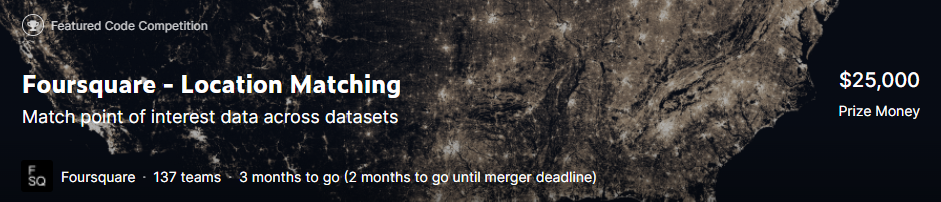

### It is to determine which location entries illustrate the same point of interest

どの場所のエントリが同じ興味のあるポイントを説明しているかを判断することです

<span style="color: orange; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">Import</span>

In [ ]:
!pip install folium
!pip install simdkalman
import os
import pickle
import sys
import warnings
from glob import glob

import folium

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
import xgboost
from scipy.stats import spearmanr
from sklearn.ensemble import (
    ExtraTreesRegressor,
    GradientBoostingRegressor,
    RandomForestRegressor,
)
from sklearn.metrics import accuracy_score, mean_squared_error
from tqdm.notebook import tqdm
pd.options.mode.use_inf_as_na = True

<span style="color: orange; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">Train</span>

In [ ]:
train = pd.read_csv('../input/foursquare-location-matching/train.csv')
train

### I want to understand point_of_interest. To try, I extract P_677e840bb6fc7e. two are shown.

point_of_interestを理解したい。試しに、P_677e840bb6fc7e を抽出する。２つ表示されている。

In [ ]:
a = train[train.point_of_interest=='P_677e840bb6fc7e'].reset_index(drop=True)
a

### Let's check these two points on the map. They point to almost the same place.

この２つのポイントを地図で確認してみよう。ほぼ同じ場所をさしている。

In [ ]:
f=folium.Figure(width=1000, height=500)
m =folium.Map([a.loc[0,'latitude'],a.loc[0,'longitude']], zoom_start=12).add_to(f)
folium.Marker(location=[a.loc[0,'latitude'],a.loc[0,'longitude']]).add_to(m)
m

In [ ]:
f=folium.Figure(width=1000, height=500)
m =folium.Map([a.loc[1,'latitude'],a.loc[1,'longitude']], zoom_start=12).add_to(f)
folium.Marker(location=[a.loc[1,'latitude'],a.loc[1,'longitude']]).add_to(m)
m

### Let's measure the distance, they are about 1 km apart.

距離を測ってみよう。1km程度離れている。

In [ ]:
from geopy.distance import geodesic
aa = a.loc[0,'latitude'],a.loc[0,'longitude']
bb = a.loc[1,'latitude'],a.loc[1,'longitude']
print(geodesic(aa,bb).km,'km')

<span style="color: orange; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">pairs</span>

In [ ]:
pairs = pd.read_csv('../input/foursquare-location-matching/pairs.csv')
pairs

In [ ]:
len(pairs.city_1.unique())

In [ ]:
len(pairs.zip_1.unique())

### Let's look at the position of the 1 side of the pair.

pairの1側の位置を見てみる。

In [ ]:
for i in tqdm(range(500)):
    plt.scatter(pairs.loc[i,'latitude_1'],pairs.loc[i,'longitude_1'])

### Let's look at the position of the 2 side of the pair.

pairの2側の位置を見てみる。

In [ ]:
for i in tqdm(range(500)):
    plt.scatter(pairs.loc[i,'latitude_2'],pairs.loc[i,'longitude_2'])

### Let's measure the difference between Pair. There is one big outlier.

Pairの差を測ってみよう。なんか１つだけでかい外れ値がある。

In [ ]:
for i in tqdm(range(500)):
    aa = pairs.loc[i,'latitude_1'],pairs.loc[i,'longitude_1']
    bb = pairs.loc[i,'latitude_2'],pairs.loc[i,'longitude_2']
    plt.scatter(i,geodesic(aa,bb).km)

### Let's look for a PAIR with a big outlier.

でかい外れ値のあるpairを探してみよう。

In [ ]:
for i in tqdm(range(500)):
    aa = pairs.loc[i,'latitude_1'],pairs.loc[i,'longitude_1']
    bb = pairs.loc[i,'latitude_2'],pairs.loc[i,'longitude_2']
    if geodesic(aa,bb).km > 50:
        print(i,geodesic(aa,bb).km)

### There is a pair that is 8478 km apart. What does it mean?

8478kmも離れているペアがありますね。なんか意味あるのか。

### Looking at the map, it doesn't look that far away.

地図をみると、そんなに離れているように見えない。

In [ ]:
f=folium.Figure(width=1000, height=500)
m =folium.Map([pairs.loc[259,'latitude_1'],pairs.loc[259,'latitude_1']], zoom_start=4).add_to(f)
folium.Marker(location=[pairs.loc[259,'latitude_1'],pairs.loc[259,'latitude_1']]).add_to(m)
m

In [ ]:
f=folium.Figure(width=1000, height=500)
m =folium.Map([pairs.loc[259,'latitude_2'],pairs.loc[259,'latitude_2']], zoom_start=4).add_to(f)
folium.Marker(location=[pairs.loc[259,'latitude_2'],pairs.loc[259,'latitude_2']]).add_to(m)
m

In [ ]:
sns.distplot(pairs['latitude_1'], bins=50, color='blue');

In [ ]:
sns.distplot(pairs['latitude_2'], bins=50, color='blue');

In [ ]:
sns.distplot(pairs['longitude_1'], bins=50, color='blue');

In [ ]:
sns.distplot(pairs['longitude_2'], bins=50, color='blue');

In [ ]:
data = pairs[:500]
qx = sns.jointplot(x=data.longitude_1, y=data.longitude_2, kind="reg")

In [ ]:
len(pairs.city_2.unique())

In [ ]:
len(pairs.zip_2.unique())

### Let's take a look at E_ffffca745329ed as a trial.

ためしにE_ffffca745329edを見てみましょう。

In [ ]:
a = pairs[pairs.id_1 =='E_ffffca745329ed'][['latitude_1', 'longitude_1','latitude_2', 'longitude_2']].reset_index(drop=True)
a

### The points indicated by PAIRS seem to be very close.

pairsで示されているポイントは非常に近いようです。

In [ ]:
f=folium.Figure(width=1000, height=500)
m =folium.Map([a.loc[0,'latitude_1'],a.loc[0,'longitude_1']], zoom_start=18).add_to(f)
folium.Marker(location=[a.loc[0,'latitude_1'],a.loc[0,'longitude_1']]).add_to(m)
m

In [ ]:
f=folium.Figure(width=1000, height=500)
m =folium.Map([a.loc[0,'latitude_1'],a.loc[0,'longitude_2']], zoom_start=18).add_to(f)
folium.Marker(location=[a.loc[0,'latitude_2'],a.loc[0,'longitude_2']]).add_to(m)
m

<span style="color: orange; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">Test</span>

### Since there are only 5 cases, I will display them all on a map.

５件しかないので、全部地図で表示してみます。

In [ ]:
test = pd.read_csv('../input/foursquare-location-matching/test.csv')
test

# 0

In [ ]:
f=folium.Figure(width=1000, height=500)
m =folium.Map([test.loc[0,'latitude'],test.loc[0,'longitude']], zoom_start=12).add_to(f)
folium.Marker(location=[test.loc[0,'latitude'],test.loc[0,'longitude']]).add_to(m)
m

# 1

In [ ]:
f=folium.Figure(width=1000, height=500)
m =folium.Map([test.loc[1,'latitude'],test.loc[1,'longitude']], zoom_start=12).add_to(f)
folium.Marker(location=[test.loc[1,'latitude'],test.loc[1,'longitude']]).add_to(m)
m

# 2

In [ ]:
f=folium.Figure(width=1000, height=500)
m =folium.Map([test.loc[2,'latitude'],test.loc[2,'longitude']], zoom_start=12).add_to(f)
folium.Marker(location=[test.loc[2,'latitude'],test.loc[2,'longitude']]).add_to(m)
m

# 3

In [ ]:
f=folium.Figure(width=1000, height=500)
m =folium.Map([test.loc[3,'latitude'],test.loc[3,'longitude']], zoom_start=12).add_to(f)
folium.Marker(location=[test.loc[3,'latitude'],test.loc[3,'longitude']]).add_to(m)
m

# 4

In [ ]:
f=folium.Figure(width=1000, height=500)
m =folium.Map([test.loc[4,'latitude'],test.loc[4,'longitude']], zoom_start=12).add_to(f)
folium.Marker(location=[test.loc[4,'latitude'],test.loc[4,'longitude']]).add_to(m)
m

### This is the submission. It seems to answer by putting the place that matches the place given in the test data.

これが提出物です。testデータで与えられた場所とマッチする場所を入れて回答するようです。

In [ ]:
sub = pd.read_csv('../input/foursquare-location-matching/sample_submission.csv')
sub